# Bilinear system identification 

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import svd
import matplotlib.pyplot as plt
from scipy.linalg import logm, expm, funm
from scipy.special import factorial

In [2]:
def response(*, Ac, Bc, Nc1, Nc2, C):
    
    def rhs_eq(x, t, u1, u2):
        """
        the rhs of the equation of motion
        """
        return (Ac + Nc1 * u1 + Nc2 * u2) @ x + Bc @ (u1, u2)
    
    time = np.arange(20)
        
    # save response when only u1 is on
    responces_1 = []
        
    # save response when only u2 is on
    responces_2 = [] 
        
    for n in range(2, 7):
        # response when only u1 is on
        y_on = odeint(rhs_eq, np.zeros(2), time[:n], args=(1., 0.))
        y_off = odeint(rhs_eq, y_on[-1], time[(n-1):], args=(0., 0.))[1:]
        
        responces_1.append(
            np.vstack([y_on, y_off]) @ C
        )
            
        # response when only u2 is on
        y_on = odeint(rhs_eq, np.zeros(2), time[:n], args=(0., 1.))
        y_off = odeint(rhs_eq, y_on[-1], time[(n-1):], args=(0., 0.))[1:]

        responces_2.append(
             np.vstack([y_on, y_off]) @ C
        )
        
    return np.array(responces_1), np.array(responces_2)

In [3]:
# Matricies from the example in paper
Ac = np.array([[-1, 0], [1, -2]])
Nc1 = np.array([[0, 0], [1, 1]])
Nc2 = np.array([[1, 1], [0, 0]])
Bc = np.array([[1, 0], [0, 1]])
C = np.array([0, 1])

In [4]:
orig_responces_1, orig_responces_2 = response(Ac=Ac, Bc=Bc, Nc1=Nc1, Nc2=Nc2, C=C)

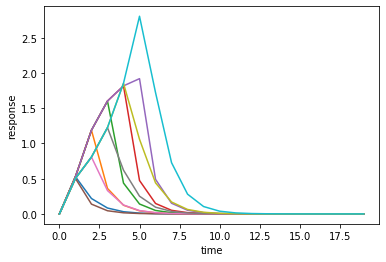

In [5]:
plt.plot(orig_responces_1.T)
plt.plot(orig_responces_2.T)
plt.xlabel("time")
plt.ylabel("response")
plt.show()

##  Going to different representation via randomly generated transformation matrix

In [6]:
Phi = np.random.rand(4).reshape(2,2) - 0.5
Phi_inv = np.linalg.inv(Phi)

In [7]:
responces_1, responces_2 = response(
    Ac= Phi_inv @ Ac @ Phi, 
    Bc= Phi_inv @ Bc, 
    Nc1= Phi_inv @ Nc1 @ Phi, 
    Nc2= Phi_inv @ Nc2 @ Phi, 
    C=C @ Phi
)

In [8]:
print("Does responces coinside?")
np.allclose(orig_responces_1, responces_1) and np.allclose(orig_responces_2, responces_2)

Does responces coinside?


True

# System identification

In [9]:
def hankel_pairs (  v = np.array([111,112,121,122,131,132]),
                    h = np.array([211,212,221,222,231,232,241,242]) ):
    v = np.asarray(v).ravel()
    h = np.asarray(h).ravel()
    a, b = np.ogrid[0:len(v), 0:len(h)]
    indx = a + b
    for i in range(1, len(v)): indx[i:, :] = indx[i:, :] + 1
    vals = np.concatenate((v, h))
    return(vals[indx[:int(len(v)/2), :]])

In [10]:
hankel_pairs()

array([[111, 112, 121, 122, 131, 132, 211, 212],
       [121, 122, 131, 132, 211, 212, 221, 222],
       [131, 132, 211, 212, 221, 222, 231, 232]])

In [11]:
Y1 = np.vstack([orig_responces_1[0], orig_responces_2[0]]).T

In [12]:
# declare parameters
m = 1 # number of outputs 
r = 2 # number of controls
alpha = 5
beta = 6

In [13]:
# Eq. (19) in [Juang - 2005]
# H1 = hankel_pairs(Y1[1:(alpha + 1)], Y1[(alpha + 1):(alpha + beta + 1)])

In [14]:
# Eq. (21) in [Juang - 2005]
# U1, Sigma1, V1_T = np.linalg.svd(H1, full_matrices=False)

In [15]:
U1, Sigma1, V1_T = np.linalg.svd(hankel_pairs(Y1[1:10], Y1[10:]), full_matrices=False)

In [16]:
Sigma1

array([8.34716021e-01, 5.42896576e-02, 1.50220561e-08, 9.75362955e-09,
       7.88578286e-09, 3.11573947e-09, 3.11081844e-09, 1.94114134e-09,
       1.79251699e-09])

In [17]:
# we see that the rank of the system is 2
rank = 2

In [18]:
# Eq. (27) in [Juang - 2005]
C_reconstructed = U1[:m, :rank]

In [19]:
C_reconstructed

array([[-0.93552331,  0.34973902]])

In [20]:
# Eqs. (29) and (30) in [Juang - 2005]
U1_up = U1[:-m,]
U1_down = U1[m:,]

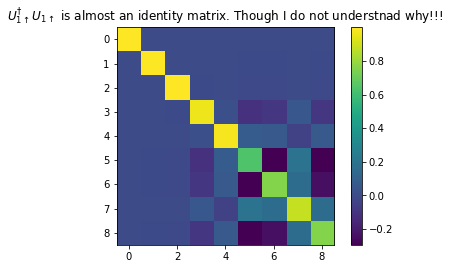

In [21]:
plt.title('$U_{1\\uparrow}^{\dagger}U_{1\\uparrow}$ is almost an identity matrix. Though I do not understnad why!!!')
plt.imshow(U1_up.conj().T @ U1_up)
plt.colorbar()
plt.show()

In [22]:
# Original Eq. (32) in [Juang - 2005], which works but I do not understand why it works 
Ac_reconstructed_original_formula = logm(
    (U1_up.conj().T @ U1_down)[:rank, :rank]
)

# I think the correct form of Eq. (32) is 
Ac_reconstructed = logm(np.linalg.lstsq(U1_up, U1_down, rcond=None)[0][:rank, :rank])

# even though the results are identical
np.allclose(Ac_reconstructed, Ac_reconstructed_original_formula)

True

In [23]:
# Eq. (28) in [Juang - 2005] 
B1_bar = (Sigma1[..., None] * V1_T)[:rank, :r] # the same as (np.diag(Sigma1) @ V1_T)[:, :r]

In [24]:
U1 = U1[:(alpha * m), :rank]
V1_T = V1_T[:(beta * r), :rank]
Sigma1 = Sigma1[:rank]

In [25]:
# !!!!!!!!!!!!!!!!!!!! this is not quite !!!!!!!!!!!!!!!!

Ac_reconstructed, np.array([[-1.0629, 3.9782], [0.0148, -1.9371]])

(array([[-1.06291753,  3.97673435],
        [ 0.01482557, -1.93708224]]),
 array([[-1.0629,  3.9782],
        [ 0.0148, -1.9371]]))

In [26]:
# Eq. (36) in [Juang - 2005] 
H2 = np.vstack([orig_responces_1[1], orig_responces_2[1]]).T
H2 = H2[2:(alpha + 2)]

In [27]:
# Note that U1 is nearly unitary, which is a good news so Eq. (38) is applicable
U1.conj().T @ U1

array([[ 9.99960101e-01, -1.68109687e-04],
       [-1.68109687e-04,  9.99291693e-01]])

In [28]:
# Eq. (38) in [Juang - 2005] 
B2_bar = U1.conj().T @ H2

In [29]:
# Eq. (41) in [Juang - 2005] 
H3 = np.vstack([orig_responces_1[2], orig_responces_2[2]]).T
H3 = H3[3:(alpha + 3)]

H4 = np.vstack([orig_responces_1[3], orig_responces_2[3]]).T
H4 = H4[4:(alpha + 4)]

H5 = np.vstack([orig_responces_1[4], orig_responces_2[4]]).T
H5 = H5[5:(alpha + 5)]

In [30]:
# Eq. (43) in [Juang - 2005]
B3_bar = U1.conj().T @ H3
B4_bar = U1.conj().T @ H4
B5_bar = U1.conj().T @ H5

In [31]:
B_bar = [B1_bar, B2_bar - B1_bar, B3_bar - B2_bar, B4_bar - B3_bar, B5_bar - B4_bar]

In [32]:
C1 = np.vstack([b[:, 0] for b in B_bar]).T
C2 = np.vstack([b[:, 1] for b in B_bar]).T

In [33]:
C1_left = C1[:, :-1]
C1_right = C1[:, 1:]

C2_left = C2[:, :-1]
C2_right = C2[:, 1:]

In [34]:
# NOTE C1_left is NOT RIGHT-UNITARY
C1_left @ C1_left.conj().T

array([[ 0.99973862, -0.08342986],
       [-0.08342986,  0.01755883]])

In [35]:
# Eq. (54) in [Juang - 2005]. I think this Eq may be incorect!!!
#log_A1_bar = logm(C1_right @ C1_left.conj().T)
#log_A2_bar = logm(C2_right @ C2_left.conj().T)

# the corrected version should be
log_A1_bar = logm(np.linalg.lstsq(C1_left.conj().T, C1_right.conj().T, rcond=None)[0].conj().T)
log_A2_bar = logm(np.linalg.lstsq(C2_left.conj().T, C2_right.conj().T, rcond=None)[0].conj().T)

Nc1_reconstructed = log_A1_bar - Ac_reconstructed
Nc2_reconstructed = log_A2_bar - Ac_reconstructed

In [36]:
def series_in_Eq52(log_A_bar):
    """
    Series in Eqs. (52) in [Juang - 2005]
    """
    
    result = np.eye(rank)
    
    r = 2

    term = np.eye(rank)
    
    while np.linalg.norm(term) > 1e-10:
        term = term @ log_A_bar
        term /= r
        r += 1
        result += term
    
    return np.linalg.inv(result) 

In [37]:
# Eqs. (52) and (53) in [Juang - 2005]
Bc_reconstructed = np.vstack([
    series_in_Eq52(log_A1_bar) @ B1_bar[:, 0], series_in_Eq52(log_A2_bar) @ B1_bar[:, 1]
]).T

## Our reconstructed responses 

In [38]:
responces_1, responces_2 = response(
    Ac = Ac_reconstructed,
    Bc = Bc_reconstructed,
    Nc1 = Nc1_reconstructed, 
    Nc2 = Nc2_reconstructed, 
    C = C_reconstructed[0]
)

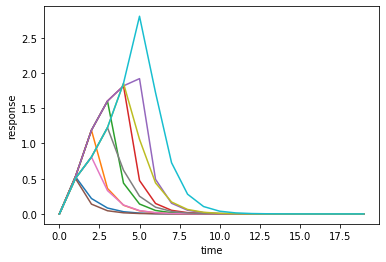

In [39]:
plt.plot(responces_1.T)
plt.plot(responces_2.T)
plt.xlabel("time")
plt.ylabel("response")
plt.show()

## Comparing to example in the paper

In [40]:
paper_responces_1, paper_responces_2 = response(
    Ac = np.array([[-1.0629, 3.9782], [0.0148, -1.9371]]),
    Bc = np.array([[-0.0929, -0.9824], [-0.2484, 0.2314]]),
    Nc1 = np.array([[1.7752, 3.2911], [-0.4182, -0.7752]]), 
    Nc2 = np.array([[0.1678, 0.3111], [0.4489, 0.8322]]), 
    C = np.array([-0.9355, 0.3497])
)

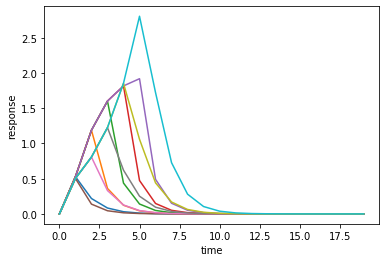

In [41]:
plt.plot(paper_responces_1.T)
plt.plot(paper_responces_2.T)
plt.xlabel("time")
plt.ylabel("response")
plt.show()

In [42]:
# difference between the response of the reconstructed model (as stated in the paper) and the original model is small
# which is GREAT
np.abs(orig_responces_1 - paper_responces_1).max(), np.abs(orig_responces_2 - paper_responces_2).max()

(0.000751094705037314, 6.668903907214307e-05)